## Leitura das bases e entendimento das volumetrias

**Problema:** Desevolvimento de um modelo para prever nota da prova de matemática (coluna NU_NOTA_MT) de quem participou do ENEM 2016.

**Target:** Note de matemática no ENEM "NU_NOTA_MT"  

**Formato de resposta:** Arquivo csv "answer.csv" com duas colunas: NU_INSCRICAO e NU_NOTA_MT.

**Métrica:** RMSE  



- Data  
- Cleaning  
- Feature Engineering  
- Model  
- Metrics  
- Repeat

In [1]:
# data processing:
import pandas as pd
from pandas.tseries.holiday import AbstractHolidayCalendar, GoodFriday, Holiday, Easter, Day, USThanksgivingDay
from pandas.tseries.offsets import DateOffset
from dateutil.relativedelta import FR, MO, SA, SU, TH, TU, WE
from pytime import pytime
from datetime import datetime
import holidays
from functools import partial

import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
import altair as alt
import scipy.stats as sct
from scipy.special import erfinv
import statsmodels.api as sm
import math
import qgrid

# estabelecendo parametro base para visualizacao via Matplotlib
from pylab import rcParams
rcParams['figure.figsize'] = 12, 6

import warnings
warnings.filterwarnings("ignore")

# Sklearn e utilidades de modelagem:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
#from sklearn.naive_bayes import GaussianNB, ComplementNB, CategoricalNB
from sklearn.svm import SVC, LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

# Preprocessamento:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
#from yellowbrick.classifier import ClassificationReport
#from yellowbrick.features import Rank2D, Rank1D
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, recall_score, f1_score, precision_score
#from imblearn.over_sampling import RandomOverSampler
#from imblearn.under_sampling import RandomUnderSampler 
from sklearn.utils import resample

In [3]:
def scale_df_cols(df, target_cols, scale_type='minmax'):
    df = df.copy()
    for col in target_cols:
        if(scale_type == 'minmax'):
            scaler = MinMaxScaler()
            X = scaler.fit_transform(np.array(df[col]).reshape(-1,1))
            df['norm_{}'.format(col)] = X
        elif(scale_type == 'standard'):
            scaler = StandardScaler()
            X = scaler.fit_transform(np.array(df[col]).reshape(-1,1))
            df['std_{}'.format(col)] = X
        elif(scale_type == 'log'):
            df['log_{}'.format(col)] = df[col].apply(np.log)
        elif(scale_type == 'gaussian_rank'):
            scaler = QuantileTransformer()
            X = scaler.fit_transform(np.array(df[col]).reshape(-1,1))
            df['qtd_{}'.format(col)] = X
    return df
    
def check_if_normal(df, col, test_type='normal'):
    # Usando o teste de Shapiro-wilk
    alpha = 0.05 # nível de significância
    to_test = np.array(df[col].values)
    
    # teste de shapiro retorna (estatística de teste, p valor)
    if(test_type == 'shapiro'):
        test_statistic, p_value = sct.shapiro(to_test)
    elif(test_type == 'jarque'):
        test_statistic, p_value = sct.jarque_bera(to_test)
    else:
        test_statistic, p_value = sct.normaltest(to_test)

    print('W =%.3f\np_value = %.3f'%(test_statistic, p_value))
    if(p_value > alpha):
        # Falhamos em rejeitar a H_O, sugerindo que a mostra pode ter vindo de uma população normalmente distribuí
        print('p_value = %.3f > alpha = %.2f' % (p_value, alpha))
        print('Não podemos rejeitar a hipótese nula, sugerindo que a amostra é proveniente de uma população normalmente distribuída')
        return True
    else:
        # Rejeitamos H_O, amostra não proveniente de uma população normalmente distribuída 
        print('p_value = %.3f <= alpha = %.2f' % (p_value, alpha))
        print('Podemos rejeitar a hipótese nula, sendo a amostra não proveniente de uma população normalmente distribuída')
        return False

In [3]:
# Base de Treino
df_train = pd.read_csv("testfiles/train.csv")
# Base de Teste
df_test = pd.read_csv("testfiles/test.csv")


NameError: name 'pd' is not defined

In [2]:
df_train.shape, df_train.NU_INSCRICAO.nunique(), df_train.NU_ANO.value_counts()

NameError: name 'df_train' is not defined

In [6]:
df_test.shape

(4576, 47)

In [7]:
pd.set_option('display.max_columns', df_train.shape[1])
df_train.head()

,Unnamed: 0,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,CO_MUNICIPIO_NASCIMENTO,NO_MUNICIPIO_NASCIMENTO,CO_UF_NASCIMENTO,SG_UF_NASCIMENTO,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,CO_ESCOLA,CO_MUNICIPIO_ESC,NO_MUNICIPIO_ESC,CO_UF_ESC,SG_UF_ESC,TP_DEPENDENCIA_ADM_ESC,TP_LOCALIZACAO_ESC,TP_SIT_FUNC_ESC,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DEFICIENCIA_AUDITIVA,IN_SURDO_CEGUEIRA,IN_DEFICIENCIA_FISICA,IN_DEFICIENCIA_MENTAL,IN_DEFICIT_ATENCAO,IN_DISLEXIA,IN_DISCALCULIA,IN_AUTISMO,IN_VISAO_MONOCULAR,IN_OUTRA_DEF,IN_SABATISTA,IN_GESTANTE,IN_LACTANTE,IN_IDOSO,IN_ESTUDA_CLASSE_HOSPITALAR,IN_SEM_RECURSO,IN_BRAILLE,IN_AMPLIADA_24,IN_AMPLIADA_18,IN_LEDOR,IN_ACESSO,IN_TRANSCRICAO,IN_LIBRAS,IN_LEITURA_LABIAL,IN_MESA_CADEIRA_RODAS,IN_MESA_CADEIRA_SEPARADA,IN_APOIO_PERNA,IN_GUIA_INTERPRETE,IN_MACA,IN_COMPUTADOR,IN_CADEIRA_ESPECIAL,IN_CADEIRA_CANHOTO,IN_CADEIRA_ACOLCHOADA,IN_PROVA_DEITADO,IN_MOBILIARIO_OBESO,IN_LAMINA_OVERLAY,IN_PROTETOR_AURICULAR,IN_MEDIDOR_GLICOSE,IN_MAQUINA_BRAILE,IN_SOROBAN,IN_MARCA_PASSO,IN_SONDA,IN_MEDICAMENTOS,IN_SALA_INDIVIDUAL,IN_SALA_ESPECIAL,IN_SALA_ACOMPANHANTE,IN_MOBILIARIO_ESPECIFICO,IN_MATERIAL_ESPECIFICO,IN_NOME_SOCIAL,IN_CERTIFICADO,NO_ENTIDADE_CERTIFICACAO,CO_UF_ENTIDADE_CERTIFICACAO,SG_UF_ENTIDADE_CERTIFICACAO,CO_MUNICIPIO_PROVA,NO_MUNICIPIO_PROVA,CO_UF_PROVA,SG_UF_PROVA,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,TP_PRESENCA_MT,CO_PROVA_CN,CO_PROVA_CH,CO_PROVA_LC,CO_PROVA_MT,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,TX_RESPOSTAS_CN,TX_RESPOSTAS_CH,TX_RESPOSTAS_LC,TX_RESPOSTAS_MT,TP_LINGUA,TX_GABARITO_CN,TX_GABARITO_CH,TX_GABARITO_LC,TX_GABARITO_MT,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,Q026,Q027,Q028,Q029,Q030,Q031,Q032,Q033,Q034,Q035,Q036,Q037,Q038,Q039,Q040,Q041,Q042,Q043,Q044,Q045,Q046,Q047,Q048,Q049,Q050
0,1,ed50e8aaa58e7a806c337585efee9ca41f1eb1ad,2016,4314902,Porto Alegre,43,RS,24,M,0.0,1,1,4314902.0,Porto Alegre,43.0,RS,1,4,1,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,4314902,Porto Alegre,43,RS,1,1,1,1,16f84b7b3d2aeaff7d2f01297e6b3d0e25c77bb2,9cd70f1b922e02bd33453b3f607f5a644fb9b1b8,01af53cd161a420fff1767129c10de560cc264dd,97caab1e1533dba217deb7ef41490f52e459ab01,436.3,495.4,581.2,399.4,ABACCABDBEDEDEEDDDBBBDAABABECDCCCAAABCBEEABCA,BBEBCAEBCEDBDDEBCACDBCBDABDDCDBEDCEAEABCAADAC,99999DCABCABCBBCADBCBBABAEADBEEBEDAAABAEAECCBB...,AECCCBABDCADDBCBCCADADBBAADEBCEEBABCDDEAABCAA,1,BCADBCEDCCBADBDCADBEBDBEADCCAEACDBEDBCACAEBEE,BCBCCADCCBEDDBEEADBDCECCBBECAEEDDADCDDACAADBA,CEDEACCBEBDBABECABDADEADCEDCBEBBCEBAAEBAAECBBC...,DADCCECBDECADCBACDBCEEABDDAABDBCEADDBECEBAEBC,1.0,120.0,120.0,120.0,80.0,80.0,520.0,D,D,B,B,3,C,A,B,B,B,A,B,A,A,A,A,A,A,B,A,A,C,A,A,A,C,H,E,5.0,5.0,1.0,0.0,0.0,5,5,0,5,5,5,5,5.0,A,A,A,A,A,A,A,B,D
1,2,2c3acac4b33ec2b195d77e7c04a2d75727fad723,2016,2304707,Granja,23,CE,17,F,0.0,3,1,2304707.0,Granja,23.0,CE,2,0,2,1.0,0,23005157.0,2304707.0,Granja,23.0,CE,2.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,2304707,Granja,23,CE,1,1,1,1,b9b06ce8c319a3df2158ea3d0aef0f7d3eecaed7,909237ab0d84688e10c0470e2997348aff585273,01af53cd161a420fff1767129c10de560cc264dd,97caab1e1533dba217deb7ef41490f52e459ab01,474.5,544.1,599.0,459.8,EDAAABDABADBCCAEDCDDECABADBEECBBAEEDCABCAABBC,ADCAABAADCEDAACDACEEDACBDCBACEDEDBACAADADABDC,99999ACBACDBDBCEADDAEEADCCEACEEDBECAAAACBECDAC...,AEDACBDECEDAEEAEDDEBDECDCECACADCACACAABDACEAB,1,EBEECADBCABECDDBEADCCABDEABEBCADBADDCCCEDBBCA,DCECBAAADCBBECAEDCEDDACCBDDACEDDBADBCADBCBCEE,CEDEACCBEBDBABECABDADEADCEDCBEBBCEBAAEBAAECBBC...,DADCCECBDECADCBACDBCEEABDDAABDBCEA

In [8]:
# Temos apenas 47 features na base de teste, portanto é interessante treinar apenas com features em comum

x_features = set.intersection(set(df_test.columns.to_list()), set(df_train.columns.to_list()))

target = df_train.NU_NOTA_MT
df_train = df_train[x_features] # 13730, 48
df_train['istrain'] = 1
df_test = df_test[x_features] # 4576, 47

df_full = pd.concat([df_train,df_test], axis = 0, sort = False).reset_index(drop = True)
df_full.istrain.fillna(0,inplace=True)

df_num = df_full.select_dtypes(exclude='object') # 18306, 33
df_str = df_full.select_dtypes(include='object') # 18306, 15

In [9]:
df_train.shape, df_test.shape, df_full.shape, df_num.shape, df_str.shape

((13730, 48), (4576, 47), (18306, 48), (18306, 33), (18306, 15))

In [10]:
print('Int64:')
print(df_full.select_dtypes(include='Int64').columns.values)
print('')
print('Float64:')
print(df_full.select_dtypes(include='Float64').columns.values)
print('')
print('Strings:')
print(df_full.select_dtypes(include='object').columns.values)

Int64:
['TP_COR_RACA' 'TP_ANO_CONCLUIU' 'CO_UF_RESIDENCIA' 'TP_PRESENCA_LC'
 'TP_NACIONALIDADE' 'IN_SURDEZ' 'TP_LINGUA' 'IN_GESTANTE'
 'TP_ST_CONCLUSAO' 'IN_SABATISTA' 'TP_PRESENCA_CN' 'IN_BAIXA_VISAO'
 'IN_DISCALCULIA' 'IN_IDOSO' 'IN_TREINEIRO' 'TP_ESCOLA' 'NU_IDADE'
 'TP_PRESENCA_CH' 'IN_DISLEXIA' 'IN_CEGUEIRA']

Float64:
['NU_NOTA_COMP4' 'NU_NOTA_COMP3' 'NU_NOTA_CH' 'TP_DEPENDENCIA_ADM_ESC'
 'TP_STATUS_REDACAO' 'TP_ENSINO' 'NU_NOTA_CN' 'NU_NOTA_COMP2'
 'NU_NOTA_COMP5' 'NU_NOTA_LC' 'NU_NOTA_REDACAO' 'NU_NOTA_COMP1' 'istrain']

Strings:
['Q001' 'CO_PROVA_LC' 'SG_UF_RESIDENCIA' 'Q002' 'Q047' 'NU_INSCRICAO'
 'Q027' 'CO_PROVA_MT' 'CO_PROVA_CH' 'Q024' 'Q026' 'CO_PROVA_CN' 'Q006'
 'TP_SEXO' 'Q025']


## Data Cleaning

- Binarização de features
- Labeling Ordinal
- Preenchimento de variáveis categóricas nulas
- Dummies
- Preenchimento de variáveis constantes nulas

In [11]:
#Returns null values (%)
def get_nans(df):
    nan_dic = {}
    for col in df.columns:
        if df[col].isnull().any() == True:
            nan_dic[col] = df[col].isnull().sum()
    return pd.DataFrame({
        'Feature': list(nan_dic.keys()),
        'Nulls': list(nan_dic.values()),
        'Percent': np.round((np.array(list(nan_dic.values())) / df.shape[0])*100, decimals = 1)
    }).sort_values('Nulls',ascending = False)

#Returns 0 values (%)

def get_zeros(df):
    zero_dic = {}
    for col in df.columns:
        if (df[col] == 0).sum() > 0:
            zero_dic[col] = (df[col] == 0).sum()
    return pd.DataFrame({'Feature': list(zero_dic.keys()),
                        'Zeros': list(zero_dic.values()),
                        'Percent': np.round((np.array(list(zero_dic.values())) / df.shape[0])*100, decimals = 1)
    }).sort_values('Zeros',ascending = False)

In [12]:
#Situação das variáveis numéricas

print('Sumário dos nulos:')
print(get_nans(df_num))
print('')
print('Sumário dos zeros:')
print(get_zeros(df_num))

Sumário dos nulos:
                   Feature  Nulls  Percent
3   TP_DEPENDENCIA_ADM_ESC  12544     68.5
5                TP_ENSINO  12544     68.5
0            NU_NOTA_COMP4   4796     26.2
1            NU_NOTA_COMP3   4796     26.2
4        TP_STATUS_REDACAO   4796     26.2
7            NU_NOTA_COMP2   4796     26.2
8            NU_NOTA_COMP5   4796     26.2
9               NU_NOTA_LC   4796     26.2
10         NU_NOTA_REDACAO   4796     26.2
11           NU_NOTA_COMP1   4796     26.2
2               NU_NOTA_CH   4523     24.7
6               NU_NOTA_CN   4523     24.7

Sumário dos zeros:
             Feature  Zeros  Percent
24       IN_CEGUEIRA  18306    100.0
13    IN_DISCALCULIA  18305    100.0
20       IN_DISLEXIA  18305    100.0
14          IN_IDOSO  18304    100.0
6          IN_SURDEZ  18300    100.0
9        IN_GESTANTE  18291     99.9
12    IN_BAIXA_VISAO  18285     99.9
10      IN_SABATISTA  18126     99.0
16      IN_TREINEIRO  15940     87.1
1    TP_ANO_CONCLUIU   9654     

In [13]:
#Situação das variáveis categóricas

print('Sumário dos nulos:')
print(get_nans(df_str))

Sumário dos nulos:
  Feature  Nulls  Percent
0    Q027   9861     53.9


In [14]:
#Cleaner

class Cleaner:
  
    from sklearn.preprocessing import MinMaxScaler
  
    def __init__(self, dataframe, bin_list = [], scaler_list = [], ordinal_list = [], dummy_list = [], clean_nan = False):    
        self.dataframe = dataframe
        self.bin_list = bin_list
        self.scaler_list = scaler_list
        self.ordinal_list = ordinal_list
        self.dummy_list = dummy_list
        self.clean_nan = clean_nan
    
    def transform(self):    
        dataframe = self.dataframe
        dataframe_cols = dataframe.columns.values.tolist()

        #Binariza
        if bool(self.bin_list):
            for col in self.bin_list:
                dataframe[col] = [0 if x == 0 else 1 for x in dataframe[col]]

        #Escalona(MinMax)
        if bool(self.scaler_list):
            scaler = MinMaxScaler()
            dataframe.loc[:,self.scaler_list] = scaler.fit_transform(dataframe.loc[:,self.scaler_list])

        #Label Ordinal  
        if bool(self.ordinal_list):
            for col in self.ordinal_list:
                dataframe[col] = dataframe[col].map({'M':13, 'K':12, 'L':11, 'J':10, 'I':9, 'H':8, 'G':7,
                                                     'F':6, 'E':5, 'D':4, 'C':3, 'B':2, 'A':1, np.nan:0})


        if bool(self.dummy_list):
            dataframe = pd.get_dummies(dataframe, columns=self.dummy_list, drop_first=True)

        if self.clean_nan:
            for col in dataframe.select_dtypes(exclude='object').columns.tolist():
                dataframe[col].fillna(dataframe[col].median(), inplace = True)

      
        return dataframe

In [15]:
df_num.columns

Index(['TP_COR_RACA', 'TP_ANO_CONCLUIU', 'NU_NOTA_COMP4', 'NU_NOTA_COMP3',
       'CO_UF_RESIDENCIA', 'TP_PRESENCA_LC', 'TP_NACIONALIDADE', 'IN_SURDEZ',
       'NU_NOTA_CH', 'TP_LINGUA', 'IN_GESTANTE', 'TP_ST_CONCLUSAO',
       'IN_SABATISTA', 'TP_PRESENCA_CN', 'IN_BAIXA_VISAO',
       'TP_DEPENDENCIA_ADM_ESC', 'TP_STATUS_REDACAO', 'IN_DISCALCULIA',
       'TP_ENSINO', 'IN_IDOSO', 'NU_NOTA_CN', 'IN_TREINEIRO', 'NU_NOTA_COMP2',
       'NU_NOTA_COMP5', 'TP_ESCOLA', 'NU_IDADE', 'TP_PRESENCA_CH',
       'IN_DISLEXIA', 'NU_NOTA_LC', 'NU_NOTA_REDACAO', 'NU_NOTA_COMP1',
       'IN_CEGUEIRA', 'istrain'],
      dtype='object')

In [16]:
df_str.columns

Index(['Q001', 'CO_PROVA_LC', 'SG_UF_RESIDENCIA', 'Q002', 'Q047',
       'NU_INSCRICAO', 'Q027', 'CO_PROVA_MT', 'CO_PROVA_CH', 'Q024', 'Q026',
       'CO_PROVA_CN', 'Q006', 'TP_SEXO', 'Q025'],
      dtype='object')

In [17]:
df_full.drop('NU_INSCRICAO', axis = 1, inplace = True)
df_str.drop('NU_INSCRICAO', axis = 1, inplace = True)

df_str.columns

Index(['Q001', 'CO_PROVA_LC', 'SG_UF_RESIDENCIA', 'Q002', 'Q047', 'Q027',
       'CO_PROVA_MT', 'CO_PROVA_CH', 'Q024', 'Q026', 'CO_PROVA_CN', 'Q006',
       'TP_SEXO', 'Q025'],
      dtype='object')

In [18]:
df_full.drop('CO_UF_RESIDENCIA', axis = 1, inplace = True)
df_num.drop('CO_UF_RESIDENCIA', axis = 1, inplace = True)

df_num.columns

Index(['TP_COR_RACA', 'TP_ANO_CONCLUIU', 'NU_NOTA_COMP4', 'NU_NOTA_COMP3',
       'TP_PRESENCA_LC', 'TP_NACIONALIDADE', 'IN_SURDEZ', 'NU_NOTA_CH',
       'TP_LINGUA', 'IN_GESTANTE', 'TP_ST_CONCLUSAO', 'IN_SABATISTA',
       'TP_PRESENCA_CN', 'IN_BAIXA_VISAO', 'TP_DEPENDENCIA_ADM_ESC',
       'TP_STATUS_REDACAO', 'IN_DISCALCULIA', 'TP_ENSINO', 'IN_IDOSO',
       'NU_NOTA_CN', 'IN_TREINEIRO', 'NU_NOTA_COMP2', 'NU_NOTA_COMP5',
       'TP_ESCOLA', 'NU_IDADE', 'TP_PRESENCA_CH', 'IN_DISLEXIA', 'NU_NOTA_LC',
       'NU_NOTA_REDACAO', 'NU_NOTA_COMP1', 'IN_CEGUEIRA', 'istrain'],
      dtype='object')

In [19]:
df_train[['SG_UF_RESIDENCIA', 'CO_UF_RESIDENCIA' ]].drop_duplicates().shape, df_train.SG_UF_RESIDENCIA.nunique(), df_train.CO_UF_RESIDENCIA.nunique()

((27, 2), 27, 27)

In [20]:
#Variáveis que são ordinais
ordinal_list = ['Q001','Q006','Q047', 'Q025', 'Q026', 'Q002', 'Q024', 'Q027']

dummy_list = ['CO_PROVA_MT', 'CO_PROVA_LC', 'SG_UF_RESIDENCIA', 'TP_SEXO', 'CO_PROVA_CN',
               'CO_PROVA_CH']


#Instânciando cleaner
cleaner = Cleaner(df_full,
                  ordinal_list = ordinal_list,
                  dummy_list = dummy_list,
                  clean_nan = True)

print(f'Shape antes do dummify: {df_full.shape}')

#Aplicando transformações
df_full = cleaner.transform()

#Shape
print(f'Shape após o dummify: {df_full.shape}')

#Verificando
df_full.head().T

Shape antes do dummify: (18306, 46)
Shape após o dummify: (18306, 101)


,0,1,2,3,4
TP_COR_RACA,1.0,3.0,3.0,0.0,2.0
TP_ANO_CONCLUIU,4.0,0.0,0.0,9.0,4.0
Q001,4.0,1.0,4.0,8.0,5.0
NU_NOTA_COMP4,80.0,120.0,120.0,120.0,120.0
NU_NOTA_COMP3,120.0,120.0,120.0,120.0,120.0
...,...,...,...,...,...
CO_PROVA_CH_9cd70f1b922e02bd33453b3f607f5a644fb9b1b8,1.0,0.0,0.0,0.0,0.0
CO_PROVA_CH_c95541bf218d7ff70572ca4bcb421edeff05c6d5,0.0,0.0,0.0,0.0,0.0
CO_PROVA_CH_d5f6d17523d2cce3e4dc0a7f0582a85cec1c15ee,0.0,0.0,0.0,0.0,0.0
CO_PROVA_CH_f48d390ab6a2428e659c37fb8a9d00afde621889,0.0,0.0,0.0,0.0,0.0


In [21]:
pd.set_option('display.max_rows', df_full.shape[1])

df_full.head().T

,0,1,2,3,4
TP_COR_RACA,1.0,3.0,3.0,0.0,2.0
TP_ANO_CONCLUIU,4.0,0.0,0.0,9.0,4.0
Q001,4.0,1.0,4.0,8.0,5.0
NU_NOTA_COMP4,80.0,120.0,120.0,120.0,120.0
NU_NOTA_COMP3,120.0,120.0,120.0,120.0,120.0
Q002,4.0,1.0,4.0,5.0,4.0
Q047,1.0,1.0,1.0,4.0,1.0
TP_PRESENCA_LC,1.0,1.0,0.0,0.0,0.0
TP_NACIONALIDADE,1.0,1.0,1.0,1.0,1.0
IN_SURDEZ,0.0,0.0,0.0,0.0,0.0


## EDA

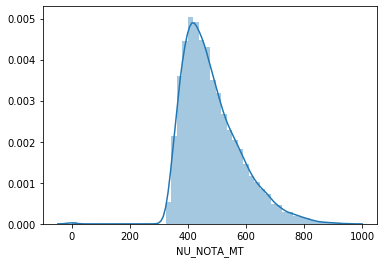

In [21]:
# Distribuição das notas de matemática (target)

sns.distplot(target[target.notnull()]);

In [ ]:
df_full

In [ ]:
#Analisando distribuições de variáveis numéricas contínuas
#Conferindo se a distribuição de treino e teste são semelhantes

cont_vars = ['NU_NOTA_CN', 'NU_NOTA_REDACAO', 'NU_IDADE', 
              'NU_NOTA_CH',
             'NU_NOTA_COMP1','NU_NOTA_COMP2', 'NU_NOTA_COMP3',
             'NU_NOTA_COMP4', 'NU_NOTA_COMP5', 'NU_NOTA_LC']
            

fig, ax = plt.subplots(2, 5, figsize = (25,10))

k = 0

for i in range(0,2):
    for j in range(0,5):
        sns.distplot(df_full.loc[df_full.istrain == 1,cont_vars[k]], ax = ax[i,j])
        sns.distplot(df_full.loc[df_full.istrain == 0,cont_vars[k]], ax = ax[i,j])
        ax[i,j].legend(['Treino', 'Teste'])
        ax[i,j].set_title(cont_vars[k])

        k += 1

#print(len(cont_vars))
#df_num.head()

In [ ]:
#Avaliando correlação

corr_data = df_full.copy()
corr_data['NU_NOTA_MT'] = target
corr_data = corr_data[['NU_NOTA_CN', 'NU_NOTA_REDACAO', 'NU_IDADE', 
              'NU_NOTA_CH', 'NU_NOTA_COMP1','NU_NOTA_COMP2', 'NU_NOTA_COMP3',
             'NU_NOTA_COMP4', 'NU_NOTA_COMP5', 'NU_NOTA_LC', 'NU_NOTA_MT']]

corr = corr_data.corr()

#Plot
fig,ax = plt.subplots(figsize=(20,20))
sns.heatmap(corr, ax = ax, annot = True)
plt.plot()

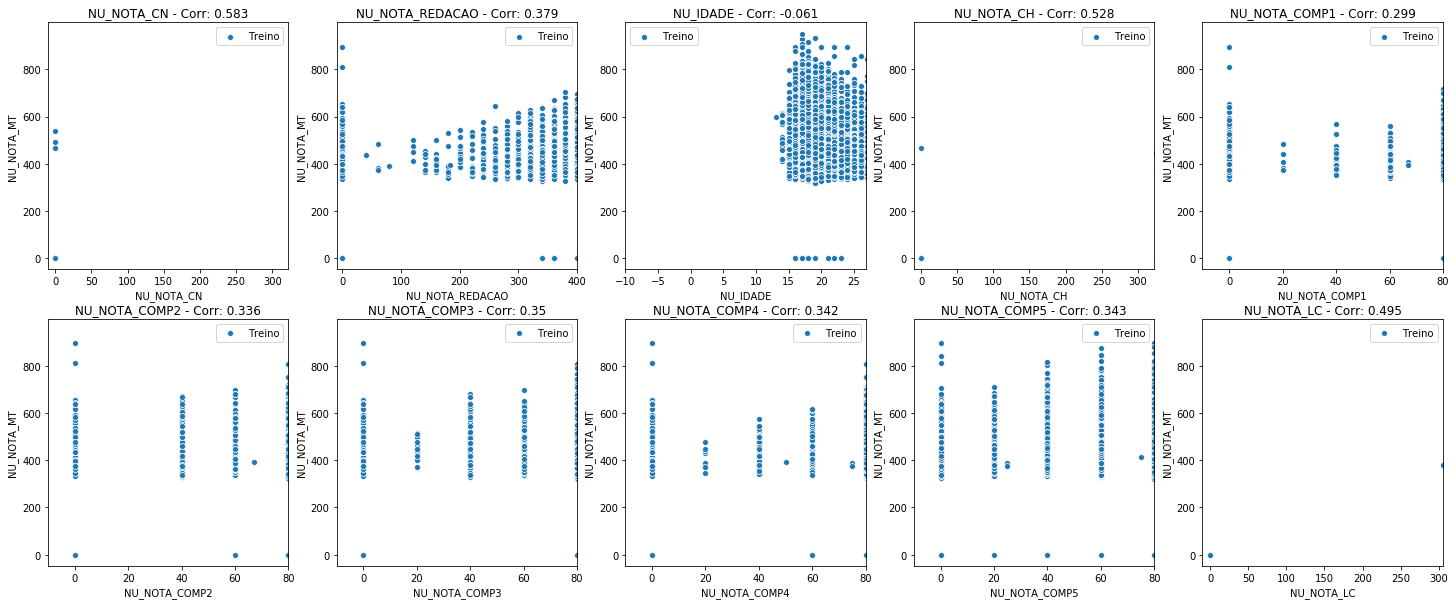

In [91]:
#Scatter
fig, ax = plt.subplots(2, 5, figsize = (25,10))

k = 0

for i in range(0,2):
    for j in range(0,5):
        xlim = ( -10, df_full.loc[df_full.istrain == 1,cont_vars[k]].max() * 0.4 )
        sns.scatterplot(x = df_full.loc[df_full.istrain == 1,cont_vars[k]],y = target, ax = ax[i,j])
        ax[i,j].legend(['Treino', 'Teste'])
        ax[i,j].set_title(f'{cont_vars[k]} - Corr: {np.round(corr.NU_NOTA_MT[k],3)}')
        ax[i,j].set_xlim(xlim)

        k += 1

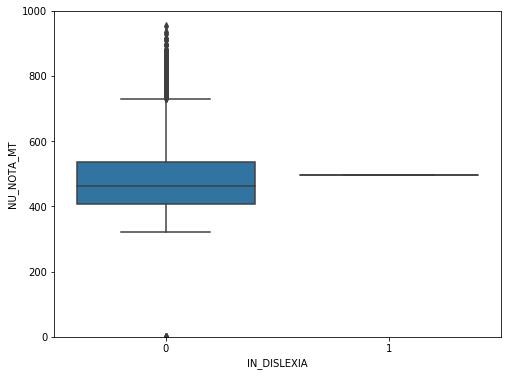

In [216]:
#box plot 
var = 'IN_DISLEXIA'
data = pd.concat([df_train['NU_NOTA_MT'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="NU_NOTA_MT", data=data)
fig.axis(ymin=0, ymax=1000);

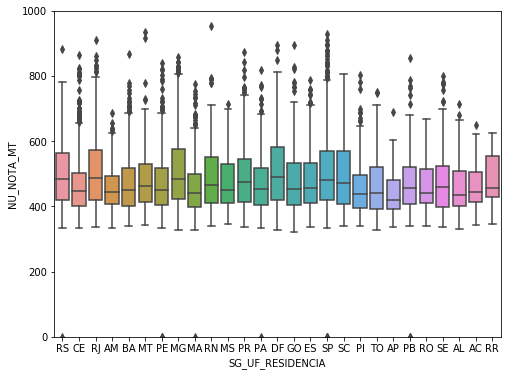

In [17]:
#box plot 
var = 'SG_UF_RESIDENCIA'
data = pd.concat([df_train['NU_NOTA_MT'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="NU_NOTA_MT", data=data)
fig.axis(ymin=0, ymax=1000);

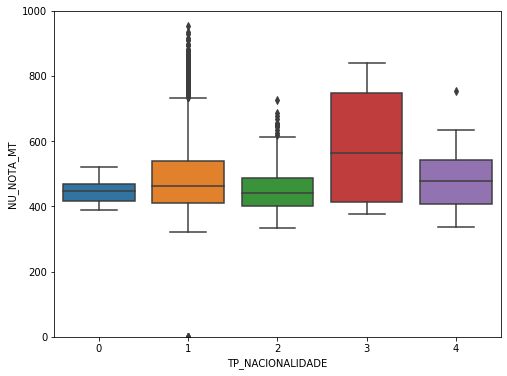

In [18]:
#box plot 
var = 'TP_NACIONALIDADE'
data = pd.concat([df_train['NU_NOTA_MT'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="NU_NOTA_MT", data=data)
fig.axis(ymin=0, ymax=1000);

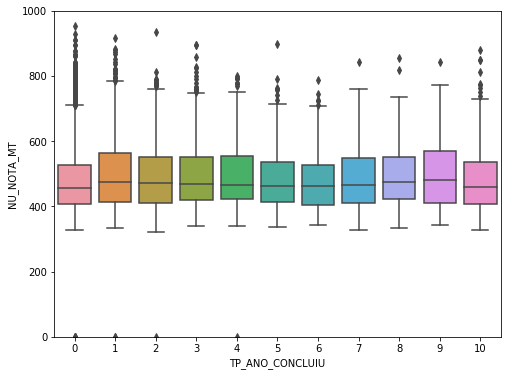

In [19]:
#box plot 
var = 'TP_ANO_CONCLUIU'
data = pd.concat([df_train['NU_NOTA_MT'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="NU_NOTA_MT", data=data)
fig.axis(ymin=0, ymax=1000);

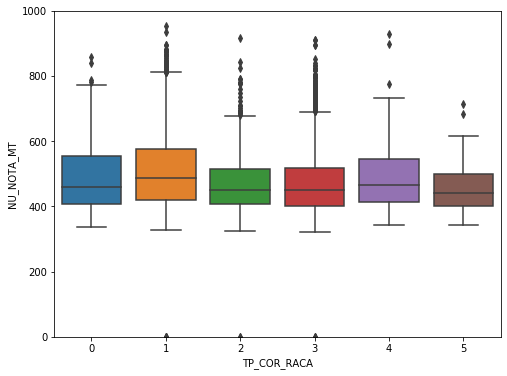

In [20]:
#box plot 
var = 'TP_COR_RACA'
data = pd.concat([df_train['NU_NOTA_MT'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="NU_NOTA_MT", data=data)
fig.axis(ymin=0, ymax=1000);

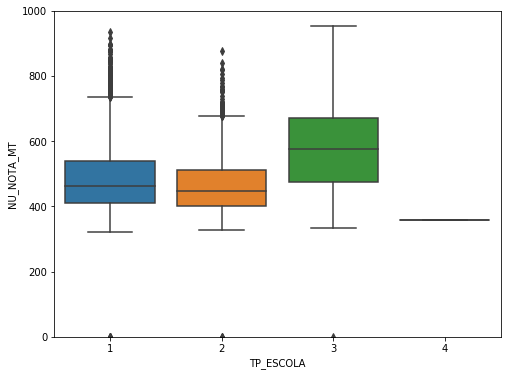

In [21]:
#box plot 
var = 'TP_ESCOLA'
data = pd.concat([df_train['NU_NOTA_MT'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="NU_NOTA_MT", data=data)
fig.axis(ymin=0, ymax=1000);

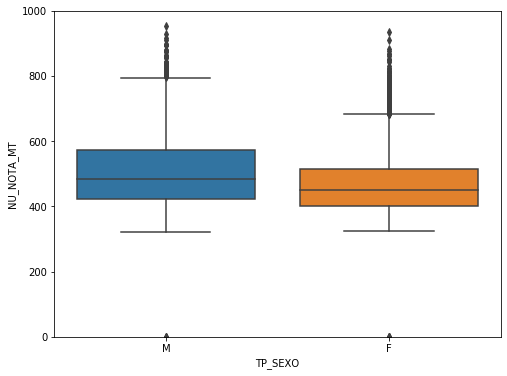

In [22]:
#box plot 
var = 'TP_SEXO'
data = pd.concat([df_train['NU_NOTA_MT'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="NU_NOTA_MT", data=data)
fig.axis(ymin=0, ymax=1000);

## Encoding and Scaling

In [22]:
def scaling(df):
    scaler = StandardScaler()
    for col in df.columns:

        if col == 'istrain':
            pass

        elif df[col].unique().tolist() != [0,1]:
            df[col] = scaler.fit_transform(df[[col]])
    return df

#Aplicando scaling
df_full = scaling(df_full)



In [23]:
#Verificando
df_full.head()

,TP_COR_RACA,TP_ANO_CONCLUIU,Q001,NU_NOTA_COMP4,NU_NOTA_COMP3,Q002,Q047,TP_PRESENCA_LC,TP_NACIONALIDADE,IN_SURDEZ,NU_NOTA_CH,TP_LINGUA,IN_GESTANTE,TP_ST_CONCLUSAO,IN_SABATISTA,TP_PRESENCA_CN,IN_BAIXA_VISAO,Q027,TP_DEPENDENCIA_ADM_ESC,TP_STATUS_REDACAO,IN_DISCALCULIA,TP_ENSINO,IN_IDOSO,NU_NOTA_CN,IN_TREINEIRO,NU_NOTA_COMP2,Q024,NU_NOTA_COMP5,Q026,TP_ESCOLA,Q006,Q025,NU_IDADE,TP_PRESENCA_CH,IN_DISLEXIA,NU_NOTA_LC,NU_NOTA_REDACAO,NU_NOTA_COMP1,IN_CEGUEIRA,istrain,CO_PROVA_MT_0ec1c8ac02d2747b6e9a99933fbf96127dd6e89e,CO_PROVA_MT_2d22ac1d42e6187f09ee6c578df187a760123ccf,CO_PROVA_MT_577f8968d95046f5eb5cc158608e12fa9ba34c85,CO_PROVA_MT_6d6961694e839531aec2d35bbd8552b55394a0d7,CO_PROVA_MT_73c5c86eef8f70263e4c5708d153cca123f93378,CO_PROVA_MT_767a32545304ed293242d528f54d4edb1369f910,CO_PROVA_MT_81d0ee00ef42a7c23eb04496458c03d4c5b9c31a,CO_PROVA_MT_97caab1e1533dba217deb7ef41490f52e459ab01,CO_PROVA_LC_01af53cd161a420fff1767129c10de560cc264dd,CO_PROVA_LC_2d22ac1d42e6187f09ee6c578df187a760123ccf,CO_PROVA_LC_44b09b311799bd684b3d02463bfa99e472c6adb3,CO_PROVA_LC_481058938110a64a272266e3892102b8ef0ca96f,CO_PROVA_LC_5aebe5cad7fabc1545ac7fba07a4e6177f98483c,CO_PROVA_LC_72f80e4b3150c627c7ffc93cfe0fa13a9989b610,CO_PROVA_LC_9cbf6bf31d9d89a64ce2737ece4834fde4a95029,CO_PROVA_LC_fa86b01f07636b15adfd66b688c79934730721a6,SG_UF_RESIDENCIA_AL,SG_UF_RESIDENCIA_AM,SG_UF_RESIDENCIA_AP,SG_UF_RESIDENCIA_BA,SG_UF_RESIDENCIA_CE,SG_UF_RESIDENCIA_DF,SG_UF_RESIDENCIA_ES,SG_UF_RESIDENCIA_GO,SG_UF_RESIDENCIA_MA,SG_UF_RESIDENCIA_MG,SG_UF_RESIDENCIA_MS,SG_UF_RESIDENCIA_MT,SG_UF_RESIDENCIA_PA,SG_UF_RESIDENCIA_PB,SG_UF_RESIDENCIA_PE,SG_UF_RESIDENCIA_PI,SG_UF_RESIDENCIA_PR,SG_UF_RESIDENCIA_RJ,SG_UF_RESIDENCIA_RN,SG_UF_RESIDENCIA_RO,SG_UF_RESIDENCIA_RR,SG_UF_RESIDENCIA_RS,SG_UF_RESIDENCIA_SC,SG_UF_RESIDENCIA_SE,SG_UF_RESIDENCIA_SP,SG_UF_RESIDENCIA_TO,TP_SEXO_M,CO_PROVA_CN_16f84b7b3d2aeaff7d2f01297e6b3d0e25c77bb2,CO_PROVA_CN_1bcdece8fb1b952552b319e4e5512bbcf540e338,CO_PROVA_CN_2d22ac1d42e6187f09ee6c578df187a760123ccf,CO_PROVA_CN_66b1dad288e13be0992bae01e81f71eca1c6e8a6,CO_PROVA_CN_69ed2ddcb151cfebe3d2ae372055335ac7c8c144,CO_PROVA_CN_a27a1efea095c8a973496f0b57a24ac6775d95b0,CO_PROVA_CN_b9b06ce8c319a3df2158ea3d0aef0f7d3eecaed7,CO_PROVA_CN_c8328ebc6f3238e06076c481bc1b82b8301e7a3f,CO_PROVA_CN_c87a85497686b3e7b3765f84a2ca95256f0f66aa,CO_PROVA_CH_2d22ac1d42e6187f09ee6c578df187a760123ccf,CO_PROVA_CH_6c3fec2ef505409a9e7c3d2e8634fa2aced4ee93,CO_PROVA_CH_909237ab0d84688e10c0470e2997348aff585273,CO_PROVA_CH_942ab3dc020af4cf53740b6b07e9dd7060b24164,CO_PROVA_CH_9cd70f1b922e02bd33453b3f607f5a644fb9b1b8,CO_PROVA_CH_c95541bf218d7ff70572ca4bcb421edeff05c6d5,CO_PROVA_CH_d5f6d17523d2cce3e4dc0a7f0582a85cec1c15ee,CO_PROVA_CH_f48d390ab6a2428e659c37fb8a9d00afde621889,CO_PROVA_CH_f94e97c2a5689edd5369740fde9a927e23a9465f
0,-1.173031,0.578611,-0.000027,-1.208530,0.327195,-0.050661,-0.387885,0.592792,-0.196049,0,-0.544356,0.822699,0,-0.892356,0,0.569829,0,1.944531,-0.199059,-0.122969,0,-0.172021,0,-0.543028,0,0.204989,-0.925446,0.055846,1.626808,-0.636895,-0.321059,-1.154498,0.345755,0.569829,0,1.092252,-0.088014,0.006796,0.0,1.0,0,0,0,0,0,0,0,2.151949,2.151949,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.821448,0,0,0,0,1.264002,2.037355,0,0,0,0,0,0,0,0,0,0,0,0,2.037355,0,0,0,0
1,0.807554,-0.665390,-1.477431,0.177373,0.327195,-1.738896,-0.387885,0.592792,-0.196049,0,0.218495,0.822699,0,0.244736,0,0.569829,0,-0.752946,-0.199059,-0.122969,0,-0.172021,0,0.073516,0,0.204989,-0.925446,0.055846,-0.856647,1.145555,-0.773857,-1.154498,-0.654759,0.569829,0,1.394827,0.366042,0.792200,0.0,1.0,0,0,0,0,0,0,0,2.151949,2.151949,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.207407,0,0,0,0,-0.791138,-0.490832,0,0,0,0,0,1,0,0,0,0,1,0,-0.490832,0,0,0,0
2,0.807554,-0.665390,-0.000027,0.177373,0.327195,-0.050661,-0.387885,-1.678377,-0.196049,0,0.028957,0.822699,0,1.381829,0,-1.745662,0,-0.752946,-0.199059,-0.122969,0,-0.172021,0,-0.170197,0,0.204989,-0.925446,0.055846,-0.856647,-0.636895,-0.321059,

In [24]:
df_full.isna().sum()

TP_COR_RACA                                             0
TP_ANO_CONCLUIU                                         0
Q001                                                    0
NU_NOTA_COMP4                                           0
NU_NOTA_COMP3                                           0
Q002                                                    0
Q047                                                    0
TP_PRESENCA_LC                                          0
TP_NACIONALIDADE                                        0
IN_SURDEZ                                               0
NU_NOTA_CH                                              0
TP_LINGUA                                               0
IN_GESTANTE                                             0
TP_ST_CONCLUSAO                                         0
IN_SABATISTA                                            0
TP_PRESENCA_CN                                          0
IN_BAIXA_VISAO                                          0
Q027          

In [56]:
#Separando
df_train = df_full.loc[df_full.istrain == 1]
df_test = df_full.loc[df_full.istrain == 0]

print(f'Train shape: {df_train.shape}')
print(f'Test shape: {df_test.shape}')
print(f'Target shape: {target.shape}')

Train shape: (13730, 101)
Test shape: (4576, 101)
Target shape: (13730,)


## Feature Selection

In [26]:
from sklearn.feature_selection import RFECV
from xgboost import XGBRegressor

In [27]:
#np.isnan(df_train.any()) #and gets False
#np.isfinite(df_train.all()) #and gets True
target[target.notnull()]

0        399.4
1        459.8
5        364.5
6        529.2
7        566.7
         ...  
13725    403.2
13726    452.4
13727    398.0
13728    386.6
13729    428.9
Name: NU_NOTA_MT, Length: 10133, dtype: float64

In [28]:
df_train.shape

(13730, 101)

### 1º treinando apenas quando o target != null para identificar variaveis mais importantes

In [29]:
clf1 = XGBRegressor()
rfecv = RFECV(estimator=clf1, step=1, cv=5,scoring='neg_mean_squared_error', n_jobs=4,verbose=1)
rfecv = rfecv.fit(df_train[target.notnull()],target[target.notnull()])

Fitting estimator with 101 features.
Fitting estimator with 100 features.
Fitting estimator with 99 features.
Fitting estimator with 98 features.
Fitting estimator with 97 features.
Fitting estimator with 96 features.
Fitting estimator with 95 features.
Fitting estimator with 94 features.
Fitting estimator with 93 features.
Fitting estimator with 92 features.
Fitting estimator with 91 features.
Fitting estimator with 90 features.
Fitting estimator with 89 features.
Fitting estimator with 88 features.
Fitting estimator with 87 features.
Fitting estimator with 86 features.
Fitting estimator with 85 features.
Fitting estimator with 84 features.
Fitting estimator with 83 features.
Fitting estimator with 82 features.
Fitting estimator with 81 features.
Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 

In [31]:
print('Numero otimo de Features : ', rfecv.n_features_)
print('Best Features : ', df_train.columns[rfecv.support_])
# aqui podemos ver as top 27 features relevantes, ainda com colinearidade entre algumas.

Numero otimo de Features :  73
Best Features :  Index(['TP_COR_RACA', 'TP_ANO_CONCLUIU', 'Q001', 'NU_NOTA_COMP4',
       'NU_NOTA_COMP3', 'Q002', 'Q047', 'TP_NACIONALIDADE', 'NU_NOTA_CH',
       'TP_LINGUA', 'TP_ST_CONCLUSAO', 'IN_SABATISTA', 'TP_PRESENCA_CN',
       'Q027', 'TP_DEPENDENCIA_ADM_ESC', 'TP_ENSINO', 'NU_NOTA_CN',
       'IN_TREINEIRO', 'NU_NOTA_COMP2', 'Q024', 'NU_NOTA_COMP5', 'Q026',
       'TP_ESCOLA', 'Q006', 'Q025', 'NU_IDADE', 'NU_NOTA_LC',
       'NU_NOTA_REDACAO', 'NU_NOTA_COMP1',
       'CO_PROVA_MT_0ec1c8ac02d2747b6e9a99933fbf96127dd6e89e',
       'CO_PROVA_MT_577f8968d95046f5eb5cc158608e12fa9ba34c85',
       'CO_PROVA_MT_6d6961694e839531aec2d35bbd8552b55394a0d7',
       'CO_PROVA_MT_73c5c86eef8f70263e4c5708d153cca123f93378',
       'CO_PROVA_MT_767a32545304ed293242d528f54d4edb1369f910',
       'CO_PROVA_MT_81d0ee00ef42a7c23eb04496458c03d4c5b9c31a',
       'CO_PROVA_MT_97caab1e1533dba217deb7ef41490f52e459ab01',
       'CO_PROVA_LC_fa86b01f07636b15adfd66b688c79934

### Machine Learning

#### Baseline

In [32]:
y = target
x = df_train

#Feature Selection
x = x.loc[:,x.columns[rfecv.support_].tolist()]
x.head()

,TP_COR_RACA,TP_ANO_CONCLUIU,Q001,NU_NOTA_COMP4,NU_NOTA_COMP3,Q002,Q047,TP_NACIONALIDADE,NU_NOTA_CH,TP_LINGUA,TP_ST_CONCLUSAO,IN_SABATISTA,TP_PRESENCA_CN,Q027,TP_DEPENDENCIA_ADM_ESC,TP_ENSINO,NU_NOTA_CN,IN_TREINEIRO,NU_NOTA_COMP2,Q024,NU_NOTA_COMP5,Q026,TP_ESCOLA,Q006,Q025,NU_IDADE,NU_NOTA_LC,NU_NOTA_REDACAO,NU_NOTA_COMP1,CO_PROVA_MT_0ec1c8ac02d2747b6e9a99933fbf96127dd6e89e,CO_PROVA_MT_577f8968d95046f5eb5cc158608e12fa9ba34c85,CO_PROVA_MT_6d6961694e839531aec2d35bbd8552b55394a0d7,CO_PROVA_MT_73c5c86eef8f70263e4c5708d153cca123f93378,CO_PROVA_MT_767a32545304ed293242d528f54d4edb1369f910,CO_PROVA_MT_81d0ee00ef42a7c23eb04496458c03d4c5b9c31a,CO_PROVA_MT_97caab1e1533dba217deb7ef41490f52e459ab01,CO_PROVA_LC_fa86b01f07636b15adfd66b688c79934730721a6,SG_UF_RESIDENCIA_AL,SG_UF_RESIDENCIA_AM,SG_UF_RESIDENCIA_AP,SG_UF_RESIDENCIA_BA,SG_UF_RESIDENCIA_CE,SG_UF_RESIDENCIA_DF,SG_UF_RESIDENCIA_ES,SG_UF_RESIDENCIA_GO,SG_UF_RESIDENCIA_MA,SG_UF_RESIDENCIA_MG,SG_UF_RESIDENCIA_MS,SG_UF_RESIDENCIA_MT,SG_UF_RESIDENCIA_PA,SG_UF_RESIDENCIA_PB,SG_UF_RESIDENCIA_PE,SG_UF_RESIDENCIA_PI,SG_UF_RESIDENCIA_PR,SG_UF_RESIDENCIA_RJ,SG_UF_RESIDENCIA_RN,SG_UF_RESIDENCIA_RO,SG_UF_RESIDENCIA_RR,SG_UF_RESIDENCIA_RS,SG_UF_RESIDENCIA_SC,SG_UF_RESIDENCIA_SE,SG_UF_RESIDENCIA_SP,SG_UF_RESIDENCIA_TO,TP_SEXO_M,CO_PROVA_CN_16f84b7b3d2aeaff7d2f01297e6b3d0e25c77bb2,CO_PROVA_CN_1bcdece8fb1b952552b319e4e5512bbcf540e338,CO_PROVA_CN_2d22ac1d42e6187f09ee6c578df187a760123ccf,CO_PROVA_CN_66b1dad288e13be0992bae01e81f71eca1c6e8a6,CO_PROVA_CN_69ed2ddcb151cfebe3d2ae372055335ac7c8c144,CO_PROVA_CN_b9b06ce8c319a3df2158ea3d0aef0f7d3eecaed7,CO_PROVA_CN_c8328ebc6f3238e06076c481bc1b82b8301e7a3f,CO_PROVA_CN_c87a85497686b3e7b3765f84a2ca95256f0f66aa,CO_PROVA_CH_f94e97c2a5689edd5369740fde9a927e23a9465f
0,-1.173031,0.578611,-0.000027,-1.208530,0.327195,-0.050661,-0.387885,-0.196049,-0.544356,0.822699,-0.892356,0,0.569829,1.944531,-0.199059,-0.172021,-0.543028,0,0.204989,-0.925446,0.055846,1.626808,-0.636895,-0.321059,-1.154498,0.345755,1.092252,-0.088014,0.006796,0,0,0,0,0,0,2.151949,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.821448,0,0,0,0,1.264002,2.037355,0,0,0,0,0,0,0,0
1,0.807554,-0.665390,-1.477431,0.177373,0.327195,-1.738896,-0.387885,-0.196049,0.218495,0.822699,0.244736,0,0.569829,-0.752946,-0.199059,-0.172021,0.073516,0,0.204989,-0.925446,0.055846,-0.856647,1.145555,-0.773857,-1.154498,-0.654759,1.394827,0.366042,0.792200,0,0,0,0,0,0,2.151949,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.207407,0,0,0,0,-0.791138,-0.490832,0,0,0,0,1,0,0,0
2,0.807554,-0.665390,-0.000027,0.177373,0.327195,-0.050661,-0.387885,-0.196049,0.028957,0.822699,1.381829,0,-1.745662,-0.752946,-0.199059,-0.172021,-0.170197,0,0.204989,-0.925446,0.055846,-0.856647,-0.636895,-0.321059,-1.154498,-0.083037,0.048540,0.063338,0.006796,0,0,0,0,0,0,-0.464695,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.207407,0,0,0,0,-0.791138,-0.490832,0,1,0,0,0,0,0,0
3,-2.163323,2.133612,1.969845,0.177373,0.327195,0.512084,2.541819,-0.196049,0.028957,-1.215511,-0.892356,0,-1.745662,1.270162,-0.199059,-0.172021,-0.170197,0,0.204989,1.838435,0.055846,1.626808,-0.636895,0.584536,0.866177,0.488686,0.048540,0.063338,0.006796,0,0,0,0,0,0,-0.464695,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,-0.207407,0,0,0,0,-0.791138,-0.490832,0,1,0,0,0,0,0,0
4,-0.182738,0.578611,0.492441,0.177373,0.327195,-0.050661,-0.387885,-0.196049,0.028957,0.822699,-0.892356,0,-1.745662,1.270162,-0.199059,-0.172021,-0.170197,0,0.204989,-0.925446,0.055846,0.385081,-0.636895,-0.321059,-1.154498,0.917478,0.048540,0.063338,0.006796,0,0,0,0,0,0,-0.464695,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.207407,0,0,0,0,1.264002,-0.490832,0,1,0,0,0,0,0,0


In [33]:
#folds = KFold(n_splits = 10)

#Model
xgb = XGBRegressor(max_depth = 3,
                   learning_rate = 0.05,
                   n_estimators = 100,
                   n_jobs = 5,
                   subsample=0.5213,
                   min_child_weight=1.7817,
                   reg_alpha=0.4640,
                   reg_lambda=0.8571,
                   gamma=0.0468,
                   colsample_bytree=0.4603
                   
                  )

#CV-Score
#print(f'Score médio para 10 folds: {cross_val_score(xgb, x, y, cv=2).mean()}')


In [34]:
print(x.shape)
print(y.shape)

(13730, 73)
(13730,)


In [35]:
y

0        399.4
1        459.8
2          NaN
3          NaN
4          NaN
         ...  
13725    403.2
13726    452.4
13727    398.0
13728    386.6
13729    428.9
Name: NU_NOTA_MT, Length: 13730, dtype: float64

In [39]:


#x.to_csv('x_selected.csv', index=False)

#y.to_csv('y_selected.csv', index = False,header='SalePrice')

In [35]:
y.fillna(0, inplace = True)#, y_test.fillna(0, inplace = True)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.4, random_state = 42)

In [37]:
y_train.fillna(0, inplace = True), y_test.fillna(0, inplace = True)

(None, None)

In [38]:
xgb.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4603, gamma=0.0468,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=3,
             min_child_weight=1.7817, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=5, num_parallel_tree=1, random_state=0,
             reg_alpha=0.464, reg_lambda=0.8571, scale_pos_weight=1,
             subsample=0.5213, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [39]:
y_pred = xgb.predict(X_test)

In [40]:
y_pred

array([ 4.1932101e+02, -3.8085055e-01,  4.4920941e+02, ...,
        4.5753204e+02, -2.8088551e+00,  4.6350900e+02], dtype=float32)

In [43]:
 y_test

12453    425.2
12095      0.0
1575     439.0
3651     874.1
586        0.0
         ...  
8496     437.5
8668     393.9
10862    466.4
4868       0.0
1298     565.7
Name: NU_NOTA_MT, Length: 5492, dtype: float64

In [41]:
from sklearn.metrics import explained_variance_score, max_error, mean_absolute_error, mean_squared_error,median_absolute_error, r2_score

print('Explained Variance Score', explained_variance_score(y_test, y_pred)) 
#The best possible score is 1.0, lower values are worse.
print('Max Error:', (max_error(y_test, y_pred)))
# maior real - predito
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
# MAE = (real - predito) / n, erro médio
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
# RMSE = raiz do quadrado do anterior
print('Median Squared Error:', median_absolute_error(y_test, y_pred))
# mediana dos (real - predito)
print('R² score:', r2_score(y_test, y_pred))

Explained Variance Score 0.9106831551385574
Max Error: 631.2190216064453
Mean Absolute Error: 46.05150355107252
Root Mean Squared Error: 68.83775549705535
Median Squared Error: 32.06016845703127
R² score: 0.9106554036351612


array([ 4.1932101e+02, -3.8085055e-01,  4.4920941e+02, ...,
        4.5753204e+02, -2.8088551e+00,  4.6350900e+02], dtype=float32)

In [162]:
x

,TP_PRESENCA_CN,NU_NOTA_LC,NU_NOTA_CN,Q002,NU_NOTA_CH,Q001,TP_DEPENDENCIA_ADM_ESC,Q026,Q047,Q006,NU_NOTA_COMP5,NU_NOTA_COMP1,IN_SABATISTA,CO_PROVA_MT_577f8968d95046f5eb5cc158608e12fa9ba34c85,CO_PROVA_MT_81d0ee00ef42a7c23eb04496458c03d4c5b9c31a,CO_PROVA_LC_fa86b01f07636b15adfd66b688c79934730721a6,SG_UF_RESIDENCIA_ES,SG_UF_RESIDENCIA_GO,SG_UF_RESIDENCIA_MA,SG_UF_RESIDENCIA_MG,SG_UF_RESIDENCIA_PA,SG_UF_RESIDENCIA_PB,SG_UF_RESIDENCIA_PE,SG_UF_RESIDENCIA_PR,SG_UF_RESIDENCIA_RS,SG_UF_RESIDENCIA_SP,TP_SEXO_M,CO_PROVA_CN_66b1dad288e13be0992bae01e81f71eca1c6e8a6,CO_PROVA_CH_f94e97c2a5689edd5369740fde9a927e23a9465f
0,0.569829,1.092252,-0.543028,-0.050661,-0.544356,-0.000027,-0.199059,1.626808,-0.387885,-0.321059,0.055846,0.006796,0,0,0,0,0,0,0,0,0,0,0,0,4.821448,0,1.264002,0,0
1,0.569829,1.394827,0.073516,-1.738896,0.218495,-1.477431,-0.199059,-0.856647,-0.387885,-0.773857,0.055846,0.792200,0,0,0,0,0,0,0,0,0,0,0,0,-0.207407,0,-0.791138,0,0
2,-1.745662,0.048540,-0.170197,-0.050661,0.028957,-0.000027,-0.199059,-0.856647,-0.387885,-0.321059,0.055846,0.006796,0,0,0,0,0,0,0,0,0,0,0,0,-0.207407,0,-0.791138,0,0
3,-1.745662,0.048540,-0.170197,0.512084,0.028957,1.969845,-0.199059,1.626808,2.541819,0.584536,0.055846,0.006796,0,0,0,0,0,0,0,0,0,0,0,0,-0.207407,0,-0.791138,0,0
4,-1.745662,0.048540,-0.170197,-0.050661,0.028957,0.492441,-0.199059,0.385081,-0.387885,-0.321059,0.055846,0.006796,0,0,0,0,0,0,0,0,0,0,0,0,-0.207407,0,1.264002,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13725,0.569829,-2.081381,-0.512362,0.512084,-1.730144,0.492441,-0.199059,0.385081,-0.387885,1.490131,-1.025263,0.006796,0,0,0,0,0,0,0,0,0,0,0,0,-0.207407,1,1.264002,1,0
13726,0.569829,0.272921,-0.744777,-1.738896,0.434663,-1.477431,-0.199059,0.385081,-0.387885,-0.321059,0.055846,0.006796,0,0,1,0,0,0,0,0,0,0,1,0,-0.207407,0,-0.791138,0,0
13727,0.569829,0.889969,-0.152443,1.637574,-0.019602,-0.492495,-0.199059,-0.856647,-0.387885,-0.773857,1.136955,0.006796,0,0,1,0,0,0,0,0,0,0,0,0,4.821448,0,-0.791138,0,0
13728,0.569829,0.884870,-0.765759,-0.050661,1.434045,-0.984963,-0.199059,1.626808,-0.387885,1.490131,0.596401,-0.778608,0,0,0,0,0,0,0,0,0,0,0,0,-0.207407,0,1.264002,1,0


In [167]:
df_test

,TP_PRESENCA_CN,NU_NOTA_LC,NU_NOTA_CN,Q002,NU_NOTA_CH,Q001,TP_DEPENDENCIA_ADM_ESC,Q026,Q047,Q006,NU_NOTA_COMP5,NU_NOTA_COMP1,IN_SABATISTA,CO_PROVA_MT_577f8968d95046f5eb5cc158608e12fa9ba34c85,CO_PROVA_MT_81d0ee00ef42a7c23eb04496458c03d4c5b9c31a,CO_PROVA_LC_fa86b01f07636b15adfd66b688c79934730721a6,SG_UF_RESIDENCIA_ES,SG_UF_RESIDENCIA_GO,SG_UF_RESIDENCIA_MA,SG_UF_RESIDENCIA_MG,SG_UF_RESIDENCIA_PA,SG_UF_RESIDENCIA_PB,SG_UF_RESIDENCIA_PE,SG_UF_RESIDENCIA_PR,SG_UF_RESIDENCIA_RS,SG_UF_RESIDENCIA_SP,TP_SEXO_M,CO_PROVA_CN_66b1dad288e13be0992bae01e81f71eca1c6e8a6,CO_PROVA_CH_f94e97c2a5689edd5369740fde9a927e23a9465f
13730,0.569829,-1.447334,-0.083041,-1.738896,-1.357334,-0.984963,-0.199059,1.626808,-0.387885,-0.321059,-1.025263,0.006796,0,0,1,0,0,0,0,0,0,0,0,1,-0.207407,0,-0.791138,0,0
13731,0.569829,0.527900,-1.272551,-1.176151,-0.611713,0.492441,-0.199059,0.385081,-0.387885,-0.321059,0.596401,0.006796,0,1,0,0,0,0,1,0,0,0,0,0,-0.207407,0,-0.791138,0,0
13732,0.569829,1.643006,2.032899,0.512084,1.449709,0.492441,-0.199059,-0.856647,-0.387885,0.131738,0.055846,-1.564013,0,0,0,0,0,0,0,0,0,0,0,0,-0.207407,0,1.264002,0,0
13733,-1.745662,0.048540,-0.170197,0.512084,0.028957,1.969845,-0.199059,-0.856647,-0.387885,1.490131,0.055846,0.006796,0,0,0,0,0,0,0,0,1,0,0,0,-0.207407,0,-0.791138,0,0
13734,0.569829,0.925666,1.984479,2.200319,-0.588216,-0.000027,-0.199059,-0.856647,-0.387885,1.942928,-2.106372,-0.778608,0,0,0,0,0,0,0,0,0,0,0,1,-0.207407,0,1.264002,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18301,0.569829,-0.090848,-1.156344,0.512084,0.439362,0.492441,-0.199059,-0.856647,-0.387885,0.131738,-1.025263,0.006796,0,0,1,0,0,0,0,0,0,0,0,1,-0.207407,0,-0.791138,0,0
18302,0.569829,-0.779290,-0.683445,-0.613406,0.776144,-0.492495,-0.199059,-0.856647,-0.387885,-0.321059,0.596401,-0.778608,0,1,0,0,0,0,0,0,0,0,0,0,-0.207407,1,1.264002,0,0
18303,0.569829,1.495118,2.731756,1.074829,1.780226,-0.000027,-0.199059,-0.856647,2.541819,0.131738,0.055846,1.577605,0,0,0,0,0,0,0,0,0,0,0,0,-0.207407,1,1.264002,0,0
18304,0.569829,0.395311,-0.691515,0.512084,-0.975125,-0.492495,-0.199059,-0.856647,-0.387885,-0.321059,0.055846,0.792200,0,1,0,0,0,1,0,0,0,0,0,0,-0.207407,0,1.264002,1,0


In [58]:
df_test = df_test.loc[:,df_test.columns[rfecv.support_].tolist()]

y_sub = xgb.predict(df_test)

y_sub

In [60]:
df_test_n = pd.read_csv("testfiles/test.csv")

In [61]:
df_test_n.shape

(4576, 47)

### Submission 01

In [62]:
# Submission
pd.DataFrame({'NU_INSCRICAO':df_test_n.NU_INSCRICAO,'NU_NOTA_MT':y_sub}).to_csv("answer_9327.csv", index= False)
pd.DataFrame({'NU_INSCRICAO':df_test_n.NU_INSCRICAO,'NU_NOTA_MT':y_sub}).to_csv("answer.csv", index= False)

In [64]:
resposta = pd.DataFrame({'NU_INSCRICAO':df_test_n.NU_INSCRICAO,'NU_NOTA_MT':y_sub})

In [79]:
resposta.loc[resposta.NU_NOTA_MT < 0 , 'NU_NOTA_MT'] = 0

In [81]:
resposta.to_csv("answer2.csv", index= False, line_terminator='\n')

In [82]:
resposta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4576 entries, 0 to 4575
Data columns (total 2 columns):
NU_INSCRICAO    4576 non-null object
NU_NOTA_MT      4576 non-null float32
dtypes: float32(1), object(1)
memory usage: 53.8+ KB


In [83]:
resposta

,NU_INSCRICAO,NU_NOTA_MT
0,73ff9fcc02f0a99919906c942c2e1a1042cdcf98,430.081146
1,71a95f9f1b91a82c65ad94abbdf9f54e6066f968,450.600433
2,b38a03232f43b11c9d0788abaf060f7366053b6d,598.308533
3,70b682d9a3636be23f6120fa9d6b164eb3c6002d,0.000000
4,715494628a50142ce8cb17191cfe6d0f3cae0934,565.238586
...,...,...
4571,dac0f22429c7f8e3931d0abaf5dfc8e5c772a48b,443.060547
4572,a75fa8770257e7c9368d059fe53d9ef431f4bdef,455.133057
4573,655fa6306720ff16e825903b5422a46608a77545,675.378357
4574,1f4bc3e3d56212d500625bfe8ac78ccff4362293,453.417145


In [78]:
pd.DataFrame({'NU_INSCRICAO':df_test_n.NU_INSCRICAO,'NU_NOTA_MT':y_sub})

,NU_INSCRICAO,NU_NOTA_MT
0,73ff9fcc02f0a99919906c942c2e1a1042cdcf98,430.081146
1,71a95f9f1b91a82c65ad94abbdf9f54e6066f968,450.600433
2,b38a03232f43b11c9d0788abaf060f7366053b6d,598.308533
3,70b682d9a3636be23f6120fa9d6b164eb3c6002d,-0.616602
4,715494628a50142ce8cb17191cfe6d0f3cae0934,565.238586
...,...,...
4571,dac0f22429c7f8e3931d0abaf5dfc8e5c772a48b,443.060547
4572,a75fa8770257e7c9368d059fe53d9ef431f4bdef,455.133057
4573,655fa6306720ff16e825903b5422a46608a77545,675.378357
4574,1f4bc3e3d56212d500625bfe8ac78ccff4362293,453.417145


In [59]:
len(y_pred)

5492

In [52]:
y_test

12453    425.2
12095      0.0
1575     439.0
3651     874.1
586        0.0
         ...  
8496     437.5
8668     393.9
10862    466.4
4868       0.0
1298     565.7
Name: NU_NOTA_MT, Length: 5492, dtype: float64

## Hyperparameter Tuning

In [51]:
from sklearn.model_selection import RandomizedSearchCV

parameters = {'objective':['reg:linear'],
              'learning_rate': [0.1, 0.2, 0.5, 0.05],
              'max_depth': [2,3,4,5,6,7],
              'min_child_weight': [0.5,1],
              'subsample': [0.25,0.5,1],
              'colsample_bytree': [0.5,1],
              'n_estimators': [50, 100, 200, 300, 500]}

rs = RandomizedSearchCV (estimator= xgb,
                        param_distributions= parameters,
                        scoring = 'neg_mean_squared_error',
                        n_jobs= 5,verbose=1,
                        n_iter = 10)

rs_result = rs.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    8.5s
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:   15.3s finished


[13:50:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[13:50:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.


In [52]:
print('Best Score: ', rs_result.best_score_)
print('Best Params: ', rs_result.best_params_)

Best Score:  -4332.173405985208
Best Params:  {'subsample': 1, 'objective': 'reg:linear', 'n_estimators': 50, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.2, 'colsample_bytree': 1}


## Validation 

In [64]:
X_test.shape

(5492, 29)

In [ ]:
X_test

In [55]:
from sklearn.preprocessing import PowerTransformer, MinMaxScaler, StandardScaler, Normalizer
from sklearn.model_selection import KFold, cross_val_score, train_test_split ,GridSearchCV, RandomizedSearchCV

# Com os resultados do RandomizedSearch
'''model = XGBRegressor(max_depth = 5,
                   learning_rate = 0.05,
                   n_estimators = 500,
                   n_jobs = 5,
                   subsample= 0.25,
                   min_child_weight=1,
              #     reg_alpha=0.4640,
               #    reg_lambda=0.8571,
                     objective = 'reg:linear',
               #    gamma=0.0468,
                   colsample_bytree=1
                   
                  )'''

model = XGBRegressor(subsample= 1, objective= 'reg:linear',
                     n_estimators= 50, in_child_weight= 1, 
                     max_depth= 4, learning_rate= 0.2, colsample_bytree= 1)


#CV

splits = 5
folds = KFold(n_splits=splits)
print(f'Score médio para {splits} splits - {cross_val_score(model, x, y).mean()}')


model.fit(X_train, y_train)
y_pred = model.predict(X_test)

err = abs(np.expm1(y_test) - np.expm1(y_pred))
err_raw = np.expm1(y_test) - np.expm1(y_pred)

err_df = pd.DataFrame({'Valor': np.expm1(y_test),
                      'Erro': err_raw,
                      'Index': y_test.index}).sort_values(by='Valor')

err_df['Cv_df'] = (err_df.Erro / err_df.Valor) * 100


print(f'Score de variância - {explained_variance_score(y_test, y_pred)}')

#fig, ax = plt.subplots(2,1,figsize=(10,6))
#sns.lineplot(x = 'Valor', y = err,data = err_df, ax = ax[0])
#ax[0].set_title(f'Erro - Std {err.std()}')
#sns.distplot(err, ax = ax[1])
#sns.lineplot(x = x_test.index, y = y_test)



[13:52:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[13:52:47] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { in_child_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:52:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[13:52:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[13:52:47] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1

In [56]:

print('Explained Variance Score', explained_variance_score(y_test, y_pred)) 
#The best possible score is 1.0, lower values are worse.
print('Max Error:', (max_error(y_test, y_pred)))
# maior real - predito
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
# MAE = (real - predito) / n, erro médio
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
# RMSE = raiz do quadrado do anterior
print('Median Squared Error:', median_absolute_error(y_test, y_pred))
# mediana dos (real - predito)
print('R² score:', r2_score(y_test, y_pred))

Explained Variance Score 0.9195873307095006
Max Error: 496.0404052734375
Mean Absolute Error: 44.213903478062555
Root Mean Squared Error: 65.31268847326464
Median Squared Error: 31.750585937500006
R² score: 0.9195714923589242


In [59]:
len(y_pred)

5492

In [57]:
# Submission
#pd.DataFrame({'NU_INSCRICAO':df_test.NU_INSCRICAO,'NU_NOTA_MT':y_sub}).to_csv("answer_9327.csv", index= False)
pd.DataFrame({'NU_INSCRICAO':df_test.NU_INSCRICAO,'NU_NOTA_MT':y_pred}).to_csv("answer.csv", index= False)

ValueError: array length 5492 does not match index length 4576

In [98]:
## Outro teste
print('Explained Variance Score', explained_variance_score(y_test, y_pred)) 
#The best possible score is 1.0, lower values are worse.
print('Max Error:', (max_error(y_test, y_pred)))
# maior real - predito
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
# MAE = (real - predito) / n, erro médio
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
# RMSE = raiz do quadrado do anterior
print('Median Squared Error:', median_absolute_error(y_test, y_pred))
# mediana dos (real - predito)
print('R² score:', r2_score(y_test, y_pred))

Explained Variance Score 0.9238095658086585
Max Error: 447.83782958984375
Mean Absolute Error: 44.03121383938578
Root Mean Squared Error: 64.43030404809608
Median Squared Error: 31.36455078124999
R² score: 0.9238070509704287


### Submission 2

In [189]:
# Submission
#pd.DataFrame({'NU_INSCRICAO':df_test.NU_INSCRICAO,'NU_NOTA_MT':y_sub}).to_csv("answer_9327.csv", index= False)
pd.DataFrame({'NU_INSCRICAO':df_test.NU_INSCRICAO,'NU_NOTA_MT':y_sub}).to_csv("answer.csv", index= False)

## Model Selection 

In [101]:
#Import de todos os possível modelos

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor


In [190]:
from sklearn.feature_selection import RFE
clf = XGBRegressor()
rfe = RFE(estimator=clf, n_features_to_select=15, step=1)
rfe = rfe.fit(X_train, y_train)
#melhores 15 features, coerente com os numeros de correlação.

In [191]:
print('Best 15 Features of Train dataset : ', X_train.columns[rfe.support_])

Best 15 Features of Train dataset :  Index(['TP_PRESENCA_CN', 'NU_NOTA_LC', 'NU_NOTA_CN', 'NU_NOTA_CH', 'Q001',
       'Q047', 'Q006', 'NU_NOTA_COMP5',
       'CO_PROVA_MT_577f8968d95046f5eb5cc158608e12fa9ba34c85',
       'CO_PROVA_MT_81d0ee00ef42a7c23eb04496458c03d4c5b9c31a',
       'CO_PROVA_LC_fa86b01f07636b15adfd66b688c79934730721a6',
       'SG_UF_RESIDENCIA_MG', 'SG_UF_RESIDENCIA_PA', 'TP_SEXO_M',
       'CO_PROVA_CH_f94e97c2a5689edd5369740fde9a927e23a9465f'],
      dtype='object')


In [195]:
features_15 = ['TP_PRESENCA_CN', 'NU_NOTA_LC', 'NU_NOTA_CN', 'NU_NOTA_CH', 'Q001',
       'Q047', 'Q006', 'NU_NOTA_COMP5',
       'CO_PROVA_MT_577f8968d95046f5eb5cc158608e12fa9ba34c85',
       'CO_PROVA_MT_81d0ee00ef42a7c23eb04496458c03d4c5b9c31a',
       'CO_PROVA_LC_fa86b01f07636b15adfd66b688c79934730721a6',
       'SG_UF_RESIDENCIA_MG', 'SG_UF_RESIDENCIA_PA', 'TP_SEXO_M',
       'CO_PROVA_CH_f94e97c2a5689edd5369740fde9a927e23a9465f']

In [193]:
rfe.support_

array([ True,  True,  True, False,  True,  True, False, False,  True,
        True,  True, False, False,  True,  True,  True, False, False,
       False,  True,  True, False, False, False, False, False,  True,
       False,  True])

In [218]:
#Instanciando os modelos (Não se preocupar com parâmetros em um primeiro momento)
import lightgbm as lgb
from sklearn.linear_model import ElasticNet


lr_model = LinearRegression() #O modelo linear apresenta problema de predição negativa (Um valor estupidamente negativo, por sinal o_O)
la_model = Lasso(alpha= 0.5)
ri_model = Ridge()
elastic_net = ElasticNet()

random_forest = RandomForestRegressor(n_estimators=100, max_depth = 6)
ada_boost = AdaBoostRegressor(n_estimators=200, learning_rate= 0.3)
gradient_boost = GradientBoostingRegressor(n_estimators=100, learning_rate=0.2)
xgb_model = XGBRegressor(max_depth = 4, learning_rate = 0.1, n_estimators = 300, objective='reg:squarederror')


In [219]:

from sklearn.metrics import mean_squared_log_error

models = [la_model, ri_model,elastic_net, random_forest, ada_boost, gradient_boost, xgb_model]
labels = ['Lasso', 'Ridge', 'Elastic Net', 'Random Forest', 'AdaBoost', 'XGB']

for label,model in zip(labels, models):
    model.fit(X_train[features_15], y_train)
    print('{}: {}'.format(label, mean_squared_error(y_test, model.predict(X_test[features_15]))))
    print('{}: {}'.format(label, r2_score(y_test, model.predict(X_test[features_15]))))
    


Lasso: 9539.47662639321
Lasso: 0.8201379924391361
Ridge: 9522.205765241835
Ridge: 0.8204636257920599
Elastic Net: 13617.758735476715
Elastic Net: 0.7432440457094135
Random Forest: 4569.293156840178
Random Forest: 0.913848288275106
AdaBoost: 4897.641617711533
AdaBoost: 0.9076574440952014
XGB: 4110.359639138099
XGB: 0.9225012476630966


In [214]:
import lightgbm as lgb

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

lgb_train = lgb.Dataset(X_train[features_15], y_train)
lgb_eval = lgb.Dataset(X_test[features_15], y_test, reference=lgb_train)

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)

y_pred = gbm.predict(X_test[features_15], num_iteration=gbm.best_iteration)

print('{}: {}'.format('LGB', mean_squared_error(y_test, y_pred)))
print('{}: {}'.format('LGB', r2_score(y_test, y_pred)))
    

[1]	valid_0's l2: 48447.2	valid_0's l1: 179.628
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l2: 44253.5	valid_0's l1: 171.303
[3]	valid_0's l2: 40442.8	valid_0's l1: 163.516
[4]	valid_0's l2: 37014.9	valid_0's l1: 156.234
[5]	valid_0's l2: 33910.4	valid_0's l1: 149.4
[6]	valid_0's l2: 31081.7	valid_0's l1: 142.937
[7]	valid_0's l2: 28532.8	valid_0's l1: 136.895
[8]	valid_0's l2: 26227.7	valid_0's l1: 131.217
[9]	valid_0's l2: 24152	valid_0's l1: 125.908
[10]	valid_0's l2: 22279.1	valid_0's l1: 120.937
[11]	valid_0's l2: 20607	valid_0's l1: 116.36
[12]	valid_0's l2: 19097	valid_0's l1: 112.068
[13]	valid_0's l2: 17735.6	valid_0's l1: 108.059
[14]	valid_0's l2: 16507.8	valid_0's l1: 104.321
[15]	valid_0's l2: 15401	valid_0's l1: 100.824
[16]	valid_0's l2: 14401.7	valid_0's l1: 97.5196
[17]	valid_0's l2: 13500.4	valid_0's l1: 94.4283
[18]	valid_0's l2: 12688.2	valid_0's l1: 91.5314
[19]	valid_0's l2: 11887.5	valid_0's l1: 88.6775
[20]	valid_0's l2: 11228.4	va